# EECS 442 Homework 4: Fashion-MNIST Classification
In this part, you will implement and train Convolutional Neural Networks (ConvNets) in PyTorch to classify images. Unlike HW4 Secion 1, backpropagation is automatically inferred by PyTorch, so you only need to write code for the forward pass.

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) David FOUHEY, #12345678

**Your Answer:**   
Wensong HU #24908654

## Setup

In [2]:
# Run the command in the terminal if it failed on local Jupyter Notebook, remove "!" before each line
# !pip install torchsummary

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split

In [4]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = 'cuda'
else:
    print("Using the CPU. Overall speed may be slowed down")
    device = 'cpu'

Using the GPU. You are good to go!


## Loading Dataset
The dataset we use is Fashion-MNIST dataset, which is available at https://github.com/zalandoresearch/fashion-mnist and in torchvision.datasets. Fashion-MNIST has 10 classes, 60000 training+validation images (we have splitted it to have 50000 training images and 10000 validation images, but you can change the numbers), and 10000 test images.

In [5]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
# Transform from [0,255] uint8 to [0,1] float,
# then normalize to zero mean and unit variance
FASHION_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.2859], [0.3530]) 
                    ])
FASHION_trainval = datasets.FashionMNIST('.', download=True, train=True,
                                         transform=FASHION_transform)
FASHION_train = Subset(FASHION_trainval, range(50000))
FASHION_val = Subset(FASHION_trainval, range(50000, 60000))
FASHION_test = datasets.FashionMNIST('.', download=True, train=False,
                                     transform=FASHION_transform)
print("Done!")

Loading datasets...
Done!


Now, we will create the dataloder for train, val and test dataset. You are free to experiment with different batch sizes.

In [6]:
# Create dataloaders
##############################################################################
# TODO: Experiment with different batch sizes                                #
##############################################################################
batch_size = 64
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
trainloader = DataLoader(FASHION_train, batch_size=batch_size, shuffle=True)
valloader = DataLoader(FASHION_val, batch_size=batch_size, shuffle=True)
testloader = DataLoader(FASHION_test, batch_size=batch_size, shuffle=True)

## Model
Initialize your model and experiment with with different optimizers, parameters (such as learning rate) and number of epochs.

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        ##############################################################################
        # TODO: Design your own network, define layers here.                          #
        # Here We provide a sample of two-layer fc network from HW4 Part3.           #
        # Your solution, however, should contain convolutional layers.               #
        # Refer to PyTorch documentations of torch.nn to pick your layers.           #
        # (https://pytorch.org/docs/stable/nn.html)                                  #
        # Some common choices: Linear, Conv2d, ReLU, MaxPool2d, AvgPool2d, Dropout   #
        # If you have many layers, use nn.Sequential() to simplify your code         #
        ##############################################################################
        # stem: 3*28*28 -> 64 * 14* 14
        self.stem = torch.nn.Sequential(torch.nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
                                        torch.nn.BatchNorm2d(64),
                                        torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        # stage1: 64 * 14 * 14 -> 64 * 14 * 14
        self.resblock1 = torch.nn.Sequential(torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                                             torch.nn.BatchNorm2d(64),
                                             torch.nn.ReLU(inplace=True),
                                             torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                                             torch.nn.BatchNorm2d(64))
        self.resblock2 = torch.nn.Sequential(torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                                             torch.nn.BatchNorm2d(64),
                                             torch.nn.ReLU(inplace=True),
                                             torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                                             torch.nn.BatchNorm2d(64))
        # stage2: 64 * 14 * 14 -> 128 * 7 * 7
        self.resblock3 = torch.nn.Sequential(torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                                             torch.nn.BatchNorm2d(128),
                                             torch.nn.ReLU(inplace=True),
                                             torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                             torch.nn.BatchNorm2d(128))
        self.resblock4 = torch.nn.Sequential(torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                             torch.nn.BatchNorm2d(128),
                                             torch.nn.ReLU(inplace=True),
                                             torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                             torch.nn.BatchNorm2d(128))
        # fc layer: 
        self.pool = torch.nn.AvgPool2d(kernel_size=7)
        self.fc = torch.nn.Sequential(torch.nn.Linear(128, 512),
                                      torch.nn.ReLU(inplace=True),
                                      torch.nn.Linear(512, 10))
        
        # downsample
        self.projection = torch.nn.Sequential(torch.nn.Conv2d(64, 128, kernel_size=1, stride=2),
                                              torch.nn.BatchNorm2d(128))
        #ReLU
        self.relu = torch.nn.ReLU(inplace=True)
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
  
    def forward(self, x):
        ##############################################################################
        # TODO: Design your own network, implement forward pass here                 # 
        ##############################################################################
        # print(x.shape)
        N, C, H, W = x.shape
        
        # stem
        x = self.stem(x)
        # print(x.shape)
        
        # stage1
        x_res = torch.clone(x)
        x = self.resblock1(x)
        x += x_res
        x = self.relu(x)
        # print(x.shape)
        
        x_res = torch.clone(x)
        x = self.resblock2(x)
        x += x_res
        x = self.relu(x)
        # print(x.shape)
        
        # stage2
        x_res = self.projection(x)
        x = self.resblock3(x)
        x += x_res
        x = self.relu(x)
        # print(x.shape)
        
        x_res = torch.clone(x)
        x = self.resblock4(x)
        x += x_res
        x = self.relu(x)
        # print(x.shape)
        
        # fc layer
        x = self.pool(x)
        # print(x.shape)
        x = torch.flatten(x, start_dim=1)
        # print(x.shape)
        x = self.fc(x)
        
        return x
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

model = Network().to(device)
criterion = nn.CrossEntropyLoss() # Specify the loss layer
print('Your network:')
print(summary(model, (1,28,28), device=device)) # visualize your model

##############################################################################
# TODO: Modify the lines below to experiment with different optimizers,      #
# parameters (such as learning rate) and number of epochs.                   #
##############################################################################
# Set up optimization hyperparameters
learning_rate, weight_decay, num_epoch = 1e-4, 0.0, 5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Your network:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           3,200
       BatchNorm2d-2           [-1, 64, 28, 28]             128
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          36,928
       BatchNorm2d-5           [-1, 64, 14, 14]             128
              ReLU-6           [-1, 64, 14, 14]               0
            Conv2d-7           [-1, 64, 14, 14]          36,928
       BatchNorm2d-8           [-1, 64, 14, 14]             128
              ReLU-9           [-1, 64, 14, 14]               0
           Conv2d-10           [-1, 64, 14, 14]          36,928
      BatchNorm2d-11           [-1, 64, 14, 14]             128
             ReLU-12           [-1, 64, 14, 14]               0
           Conv2d-13           [-1, 64, 14, 14]          36,928
      BatchNorm2d-14     

Run the cell below to start your training, we expect you to achieve over **85%** on the test set. A valid solution that meet the requirement take no more than **10 minutes** on normal PC Intel core CPU setting. If your solution takes too long to train, try to simplify your model or reduce the number of epochs.

In [8]:
%%time
def train(model, trainloader, valloader, num_epoch=10):  # Train the model
    print("Start training...")
    trn_loss_hist = []
    trn_acc_hist = []
    val_acc_hist = []
    model.train()  # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        print('-----------------Epoch = %d-----------------' % (i+1))
        for batch, label in tqdm(trainloader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad()  # Clear gradients from the previous iteration
            # This will call Network.forward() that you implement
            pred = model(batch)
            loss = criterion(pred, label)  # Calculate the loss
            running_loss.append(loss.item())
            loss.backward()  # Backprop gradients to all tensors in the network
            optimizer.step()  # Update trainable weights
        print("\n Epoch {} loss:{}".format(i+1, np.mean(running_loss)))

        # Keep track of training loss, accuracy, and validation loss
        trn_loss_hist.append(np.mean(running_loss))
        trn_acc_hist.append(evaluate(model, trainloader))
        print("\n Evaluate on validation set...")
        val_acc_hist.append(evaluate(model, valloader))
    print("Done!")
    return trn_loss_hist, trn_acc_hist, val_acc_hist


def evaluate(model, loader):  # Evaluate accuracy on validation / test set
    model.eval()  # Set the model to evaluation mode
    correct = 0
    with torch.no_grad():  # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred, dim=1) == label).sum().item()
        acc = correct/len(loader.dataset)
        print("\n Evaluation accuracy: {}".format(acc))
        return acc


trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, trainloader,
                                                  valloader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
evaluate(model, testloader)
#5: 64, 1e-4, 0.95, 5: 0.7843
#6: 64, 1e-4, 0.98, 5: 0.7851
#7: 64, 1e-4, 0.00, 5: 0.8917

Start training...
-----------------Epoch = 1-----------------


  0%|          | 0/782 [00:00<?, ?it/s]100%|██████████| 782/782 [00:13<00:00, 59.46it/s]



 Epoch 1 loss:0.5725756988424779


100%|██████████| 782/782 [00:07<00:00, 99.74it/s] 



 Evaluation accuracy: 0.83086

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 96.58it/s] 



 Evaluation accuracy: 0.8212
-----------------Epoch = 2-----------------


100%|██████████| 782/782 [00:12<00:00, 61.51it/s]



 Epoch 2 loss:0.38106703539105025


100%|██████████| 782/782 [00:07<00:00, 101.50it/s]



 Evaluation accuracy: 0.89394

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 98.84it/s]



 Evaluation accuracy: 0.8852
-----------------Epoch = 3-----------------


100%|██████████| 782/782 [00:12<00:00, 61.09it/s]



 Epoch 3 loss:0.31754977807707496


100%|██████████| 782/782 [00:07<00:00, 102.77it/s]



 Evaluation accuracy: 0.89466

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 97.87it/s]



 Evaluation accuracy: 0.8833
-----------------Epoch = 4-----------------


100%|██████████| 782/782 [00:12<00:00, 61.65it/s]



 Epoch 4 loss:0.2882935323983507


100%|██████████| 782/782 [00:07<00:00, 101.61it/s]



 Evaluation accuracy: 0.89676

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 101.90it/s]



 Evaluation accuracy: 0.8843
-----------------Epoch = 5-----------------


100%|██████████| 782/782 [00:12<00:00, 61.54it/s]



 Epoch 5 loss:0.2685324148086788


100%|██████████| 782/782 [00:07<00:00, 99.73it/s] 



 Evaluation accuracy: 0.9109

 Evaluate on validation set...


100%|██████████| 157/157 [00:01<00:00, 101.33it/s]



 Evaluation accuracy: 0.8966
Done!

 Evaluate on test set


100%|██████████| 157/157 [00:01<00:00, 103.19it/s]


 Evaluation accuracy: 0.8917
CPU times: user 1min 54s, sys: 512 ms, total: 1min 54s
Wall time: 1min 52s


0.8917

Once your training is complete, run the cell below to visualize the training and validation accuracies across iterations.

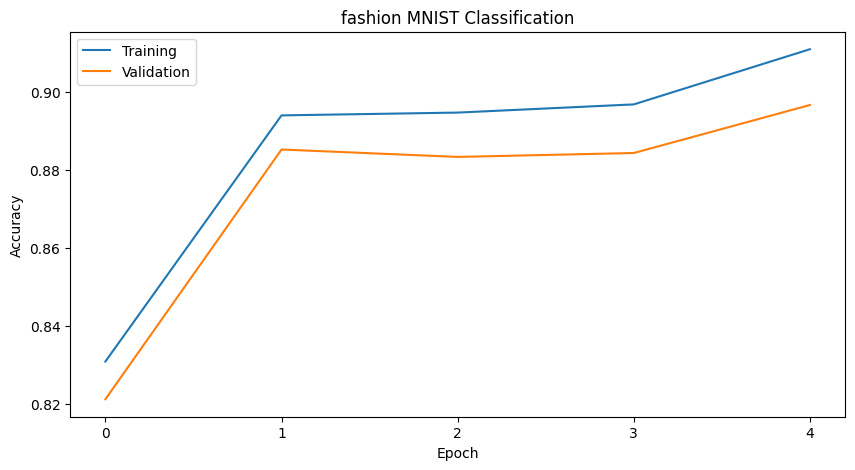

In [9]:
##############################################################################
# TODO: Submit the accuracy plot                                             #
##############################################################################
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('fashion MNIST Classification')
plt.gcf().set_size_inches(10, 5)
plt.savefig('part1.png', dpi=300)
plt.show()